In [4]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [5]:
images = glob.glob('camera_cal/calibration*.jpg')

nx = 9
ny = 6

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    #Converting an image, imported by cv2 or the glob API, to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #Finding chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)

#Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )


In [6]:
# Load distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [7]:
# undistort image using camera calibration matrix from above
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

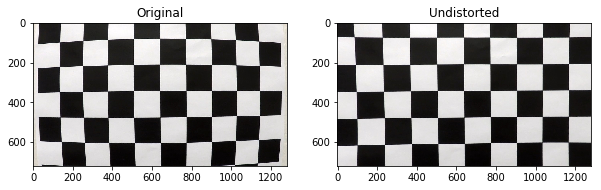

In [8]:
# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

dst=undistort(img)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(img)
axes[0].set_title('Original')
axes[1].imshow(dst)
axes[1].set_title('Undistorted')

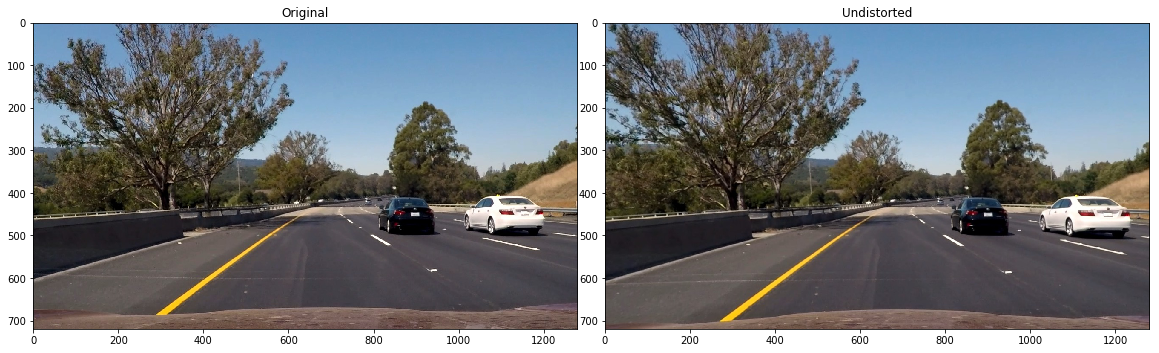

In [9]:
# Test undistortion on an image
img = mpimg.imread('test_images/test6.jpg')
img_size = (img.shape[1], img.shape[0])

dst=undistort(img)

fig, axes = plt.subplots(1, 2,figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
axes[0].imshow(img)
axes[0].set_title('Original')
axes[1].imshow(dst)
axes[1].set_title('Undistorted')

In [10]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

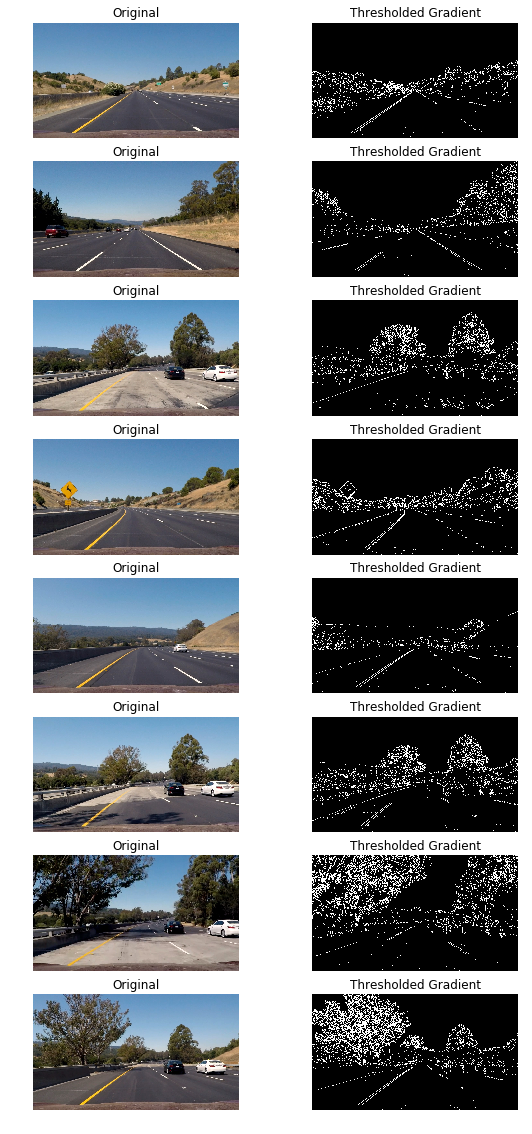

In [11]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    absSobelImg = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('Original')
    i += 1
    axs[i].imshow(absSobelImg, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title('Thresholded Gradient')
    i += 1


In [12]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

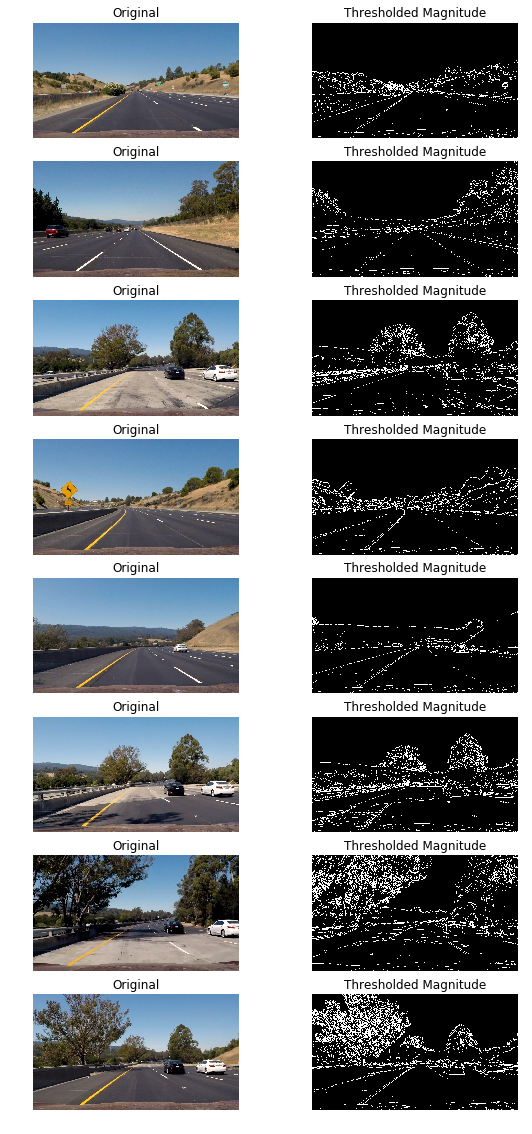

In [13]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    absSobelImg = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('Original')
    i += 1
    axs[i].imshow(absSobelImg, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title('Thresholded Magnitude')
    i += 1

In [14]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

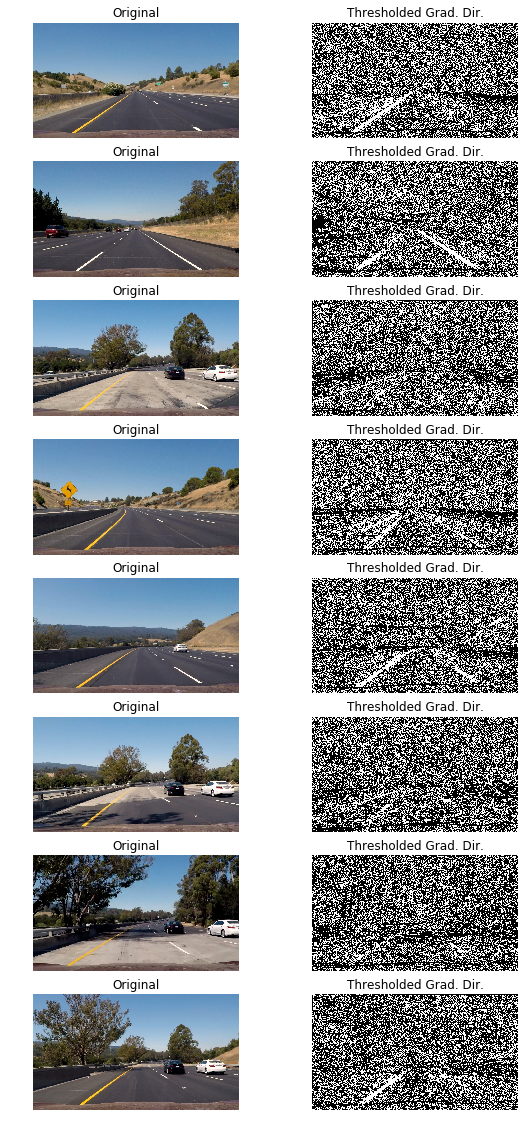

In [15]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    absSobelImg = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('Original')
    i += 1
    axs[i].imshow(absSobelImg, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title('Thresholded Grad. Dir.')
    i += 1

In [16]:
def combined_thresholded(img):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

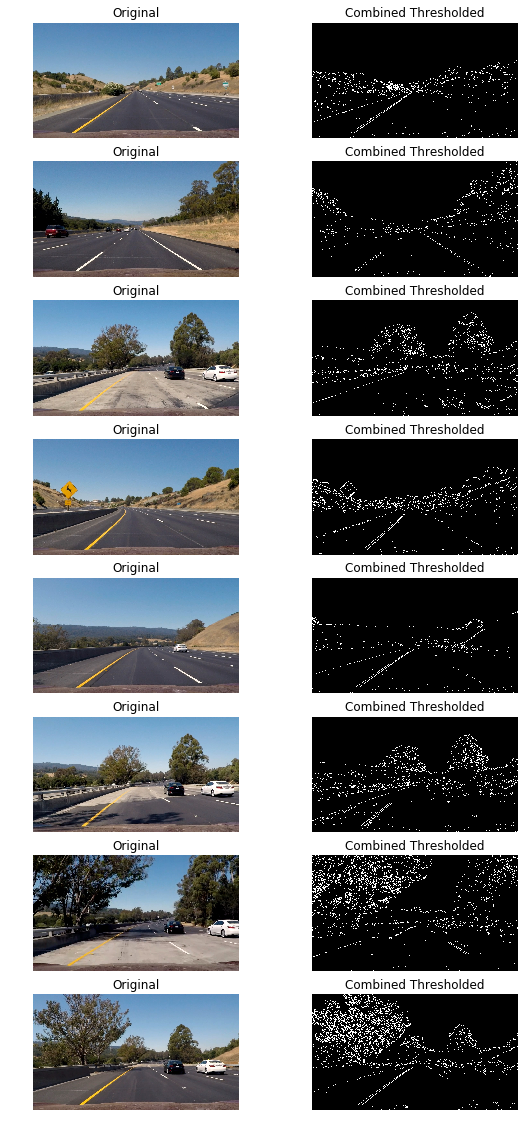

In [17]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    absSobelImg = combined_thresholded(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('Original')
    i += 1
    axs[i].imshow(absSobelImg, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title('Combined Thresholded')
    i += 1

In [18]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#hls_binary = hls_select(image, thresh=(90, 255))

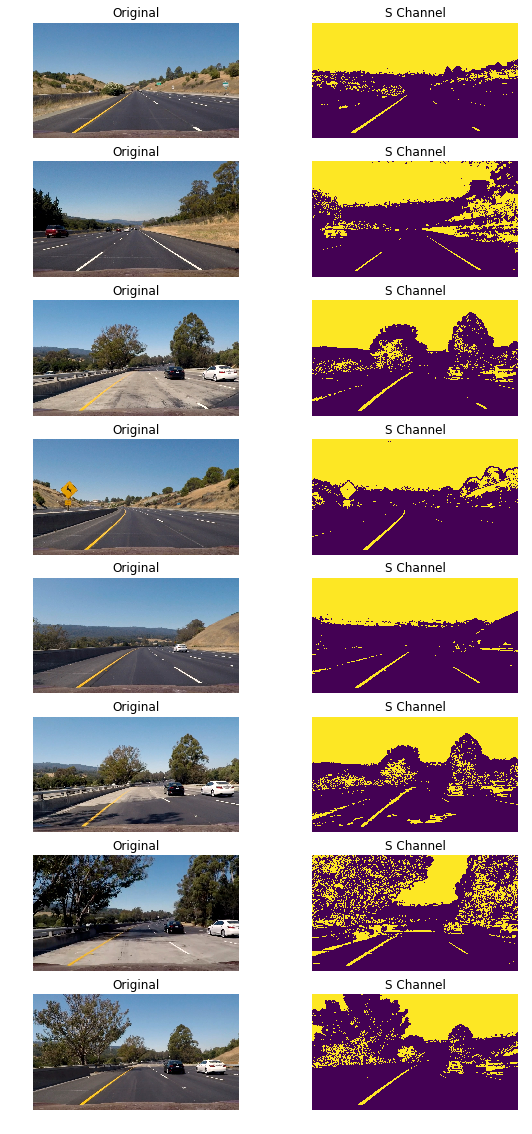

In [19]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    absSobelImg = hls_select(img,thresh=(90, 255))
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('Original')
    i += 1
    axs[i].imshow(absSobelImg)
    axs[i].axis('off')
    axs[i].set_title('S Channel')
    i += 1

In [20]:
def corners_unwarp(img):
    img = undistort(img)
    #src = np.float32([[590,450],[800,450],[1140,670],[225,670]])
    src = np.float32([[590,450],[700,450],[1133,680],[225,680]])
    offset = 100 # offset for dst points
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    return warped,Minv

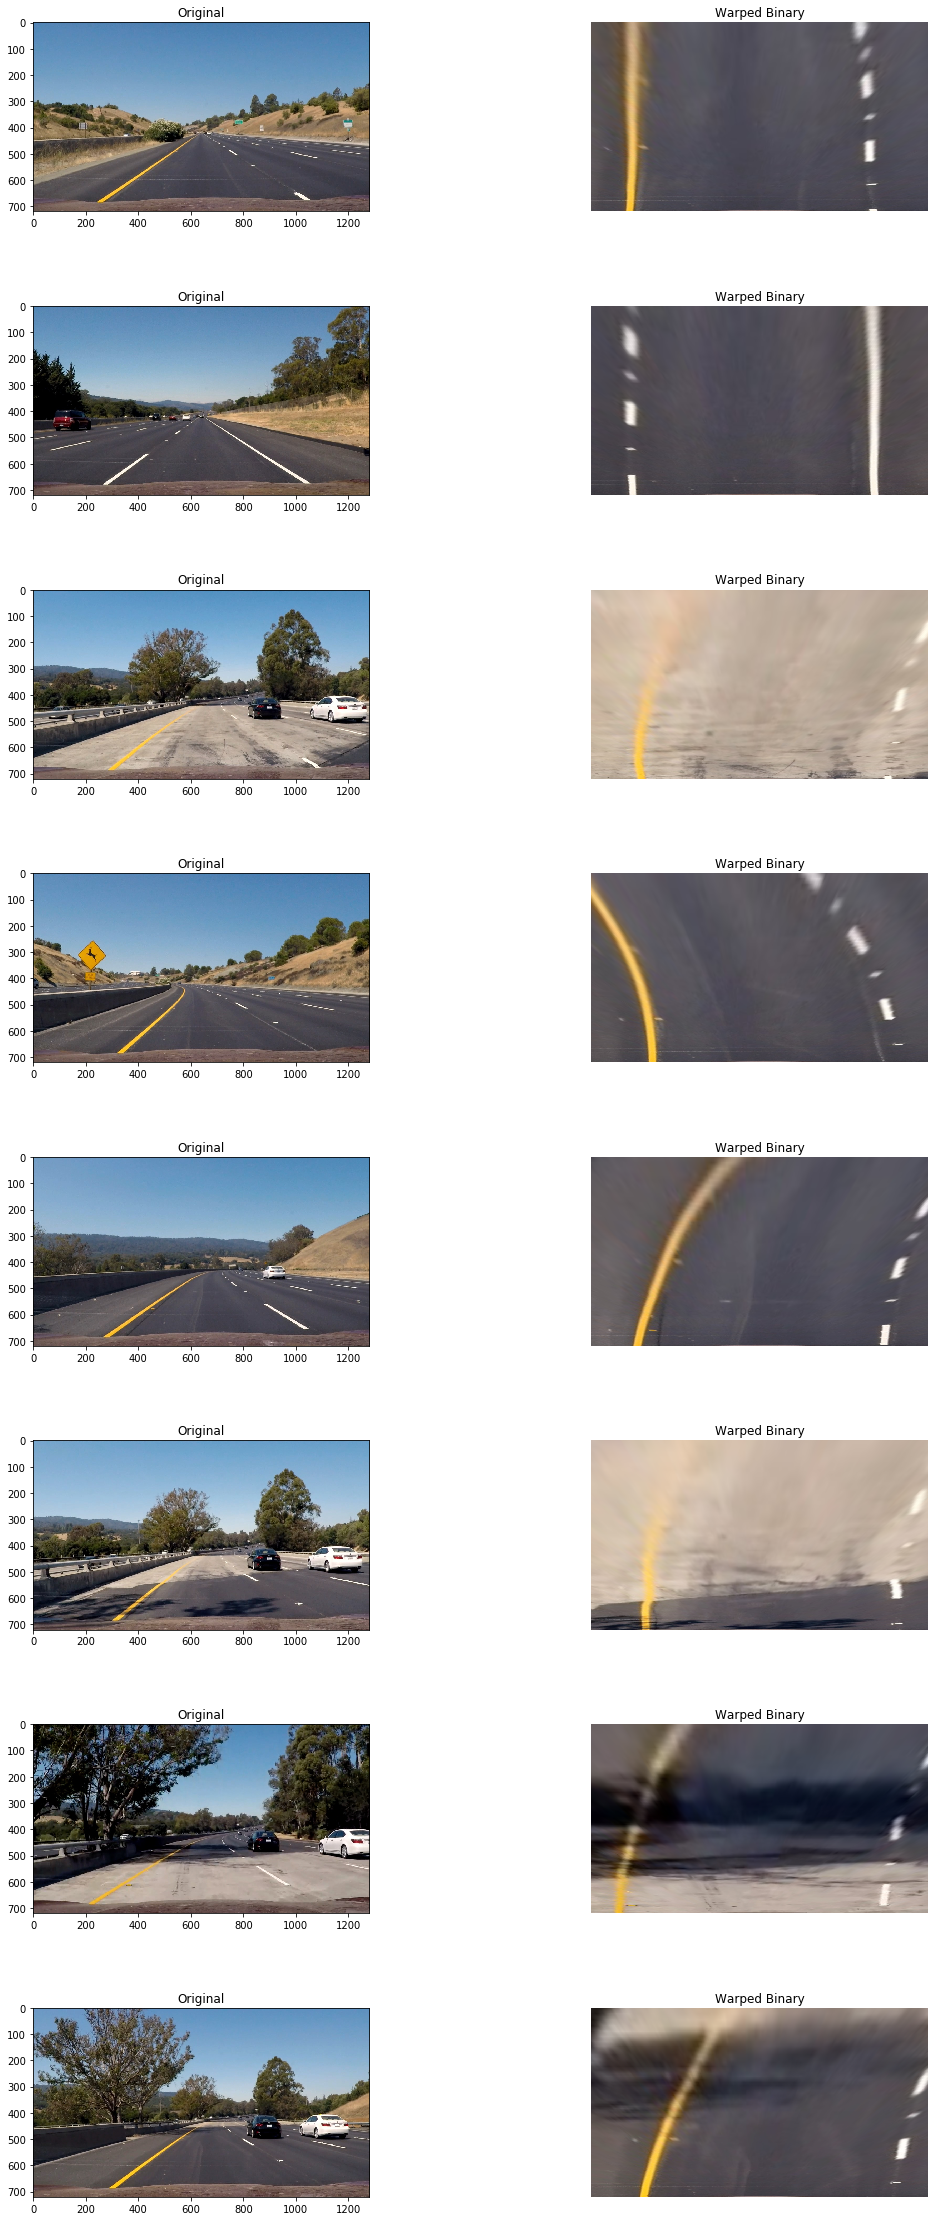

In [21]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(20, 40))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    absSobelImg, Minv = corners_unwarp(img)
    axs[i].imshow(img)
    #axs[i].axis('off')
    axs[i].set_title('Original')
    i += 1
    axs[i].imshow(absSobelImg)
    axs[i].axis('off')
    axs[i].set_title('Warped Binary')
    i += 1

In [22]:
def pipeline(img, s_thresh=(120, 255), sx_thresh=(20, 255), lx_thresh=(40,255)):
    img = np.copy(img)
    undist_image = undistort(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= lx_thresh[0]) & (l_channel <= lx_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( l_binary , sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(l_binary == 1) & (s_binary == 1) | (sxbinary == 1)] = 1
    #combined_binary = 255*np.dstack((combined_binary,combined_binary,combined_binary)).astype('uint8')  
    
    warped_binary, Minv = corners_unwarp(combined_binary)
    return warped_binary, Minv

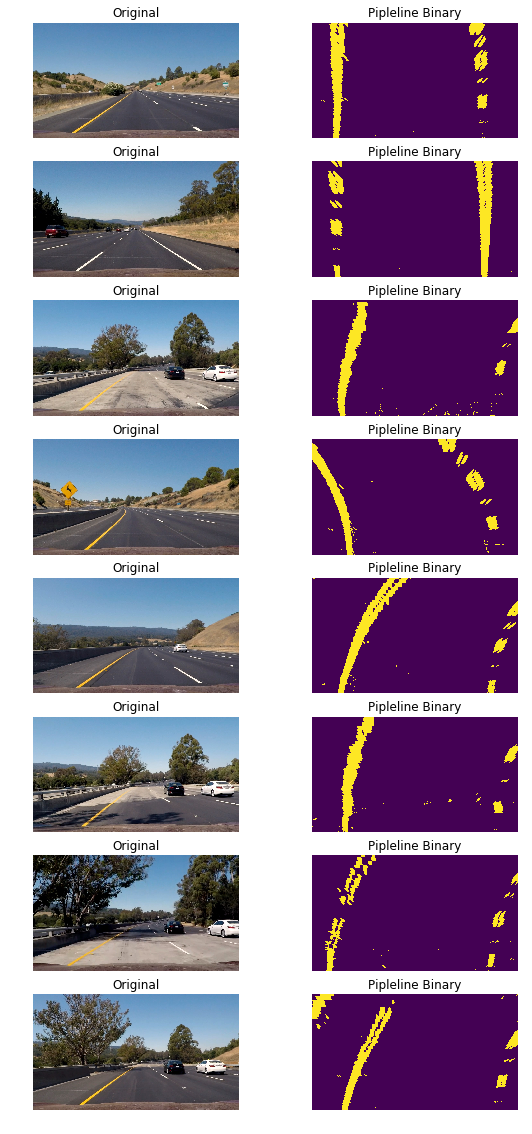

In [23]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
j=0
for image in images:
    #image_name = "output_images/pipeline_binary/" + os.path.split(images[j])[1]
    
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pipeline_img, Minv = pipeline(img,s_thresh=(120, 255), sx_thresh=(20, 255),lx_thresh=(40,255))
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('Original')
    i += 1
    axs[i].imshow(pipeline_img)
    axs[i].axis('off')
    axs[i].set_title('Pipleline Binary')
    #cv2.imwrite(image_name, pipeline_img)
    i += 1
    j +=1
    

In [24]:
def sliding_window_polyfit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    #plt.imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    #print(window_height)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
                
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #print(left_fit)
    #print(right_fit)
    
    return left_fit, right_fit, out_img,left_lane_inds,right_lane_inds

In [25]:
def plot_sliding_window(binary_warped, left_fit, right_fit, out_img,left_lane_inds,right_lane_inds):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return out_img

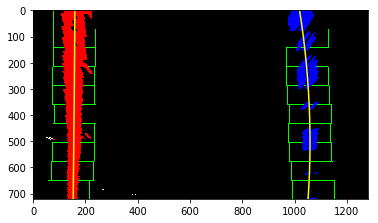

In [26]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
img = cv2.imread(images[0])

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pipe_binary,Minv = pipeline(img,s_thresh=(120, 255), sx_thresh=(20, 255),lx_thresh=(40,255))

left_fit, right_fit, out_img,left_lane_inds,right_lane_inds = sliding_window_polyfit(pipe_binary)
out_img = plot_sliding_window(pipe_binary,left_fit, right_fit, out_img,left_lane_inds,right_lane_inds)
#image_name = "output_images/sliding_window/" + os.path.split(images[0])[1]
#cv2.imwrite(image_name, out_img)


In [27]:
def sliding_window_polyfit_next(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    return binary_warped,left_fit,right_fit,left_lane_inds,right_lane_inds

In [28]:
def plot_sliding_window_next(binary_warped,left_fit,right_fit,left_lane_inds,right_lane_inds):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 80
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)     
    return result

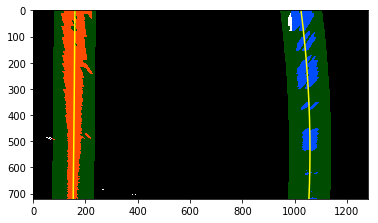

In [29]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
img1 = cv2.imread(images[1])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread(images[0])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

pipe_binary,Minv = pipeline(img1,s_thresh=(120, 255), sx_thresh=(20, 255),lx_thresh=(40,255))
left_fit, right_fit, out_img,left_lane_inds,right_lane_inds = sliding_window_polyfit(pipe_binary)
pipe_binary2,Minv = pipeline(img2,s_thresh=(120, 255), sx_thresh=(20, 255),lx_thresh=(40,255))
binary_warped,left_fit,right_fit,left_lane_inds,right_lane_inds = sliding_window_polyfit_next(pipe_binary2, left_fit, right_fit)
result = plot_sliding_window_next(pipe_binary2,left_fit,right_fit,left_lane_inds,right_lane_inds)
#image_name = "output_images/prev_sliding_window/" + os.path.split(images[0])[1]
#cv2.imwrite(image_name, result)



In [30]:
def calc_curvature(binary_warped,left_fit, right_fit, left_lane_inds, right_lane_inds):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    if len(leftx) != 0 and len(rightx) != 0:

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
    
    
    if right_fit is not None and left_fit is not None:
        car_position = binary_warped.shape[1]/2
        left_c = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_c = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

        lane_center_position = (right_c + left_c) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return left_curverad,right_curverad,center_dist


In [31]:
def draw_lane(img, binary_warped, left_fit, right_fit, Minv,left_curverad,right_curverad,center_dist):
    new_img = np.copy(img)
    if left_fit is None or right_fit is None:
        return img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_warped.shape
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    #cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)    
    return result

In [32]:
def draw_curvature(draw_img, left_curverad, right_curverad, center_dist):
    curv = (left_curverad+right_curverad)/2
    new_img = np.copy(draw_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

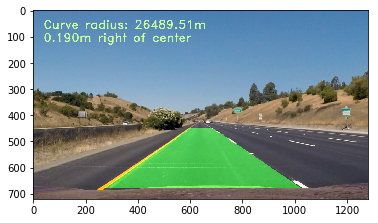

In [33]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
img1 = cv2.imread(images[1])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread(images[0])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
                    
pipe_binary, Minv = pipeline(img1,s_thresh=(120, 255), sx_thresh=(20, 255),lx_thresh=(40,255))
left_fit, right_fit, out_img,left_lane_inds,right_lane_inds = sliding_window_polyfit(pipe_binary)
                    
pipe_binary2,Minv = pipeline(img2,s_thresh=(120, 255), sx_thresh=(20, 255),lx_thresh=(40,255))
binary_warped,left_fit,right_fit,left_lane_inds,right_lane_inds = sliding_window_polyfit_next(pipe_binary2, left_fit, right_fit)
                    

left_curverad,right_curverad,center_dist = calc_curvature(pipe_binary2,left_fit, right_fit, left_lane_inds, right_lane_inds)
draw_img = draw_lane(img, pipe_binary2, left_fit, right_fit, Minv,left_curverad,right_curverad,center_dist)
draw_curv_img = draw_curvature(draw_img, left_curverad, right_curverad, center_dist)

plt.imshow(draw_curv_img)

In [34]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allxy = None  
        
    
    # saving the best fit
    def save_fit(self, fit, inds):
        
        if fit is not None:
            if self.best_fit is not None:
                # see how best fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:                
                self.detected = False
                #print("FALSEEEE")
            else:
                self.detected = True
                self.allxy = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # remove older and keep the new one
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                #avg best fit
                self.best_fit = np.average(self.current_fit, axis=0)
        
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # remove older fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
                # avg best fit
                self.best_fit = np.average(self.current_fit, axis=0)

In [35]:
def process_image(img):
    new_img = np.copy(img)
    img_binary, Minv = pipeline(new_img,s_thresh=(120, 255), sx_thresh=(20, 255),lx_thresh=(40,255))
    
    # if lines were detected, use previous fit, otherwise get best fit
    if l_line.detected and r_line.detected:
        binary_warped,left_fit,right_fit,left_lane_inds,right_lane_inds = sliding_window_polyfit_next(img_binary, l_line.best_fit, r_line.best_fit)
    else:
        left_fit, right_fit, out_img,left_lane_inds,right_lane_inds = sliding_window_polyfit(img_binary)
               
    l_line.save_fit(left_fit, left_lane_inds)
    r_line.save_fit(right_fit, right_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        left_curverad,right_curverad,center_dist = calc_curvature(img_binary,l_line.best_fit, r_line.best_fit, left_lane_inds, right_lane_inds)
        draw_img = draw_lane(new_img, img_binary, l_line.best_fit, r_line.best_fit, Minv,left_curverad,right_curverad,center_dist)
        draw_curv_img = draw_curvature(draw_img, left_curverad, right_curverad, center_dist)
    else:
        draw_curv_img = new_img
    
    return draw_curv_img


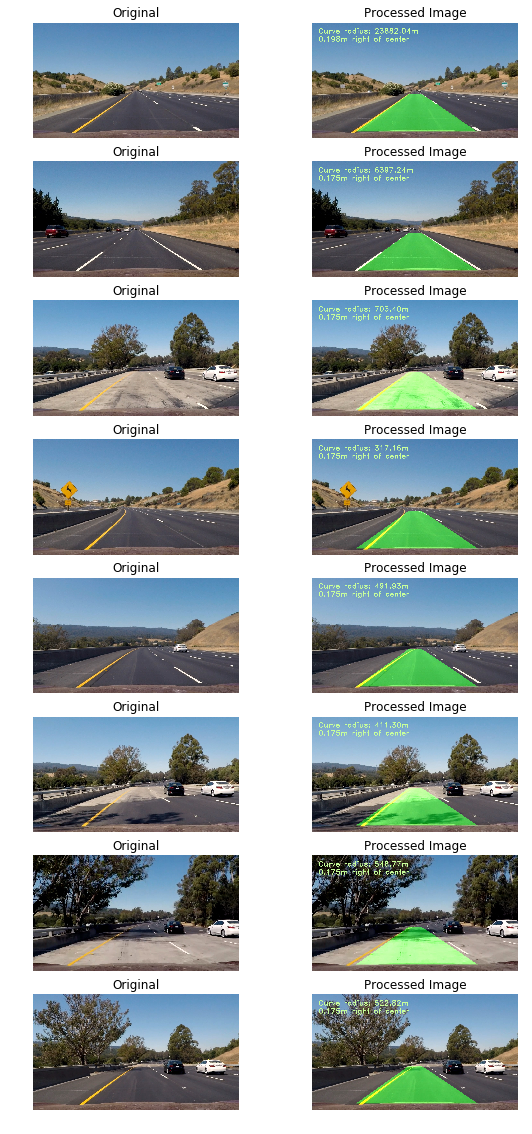

In [36]:
l_line = Line()
r_line = Line()

# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
j=0
for image in images:    
    image_name = "output_images/final_images/" + os.path.split(images[j])[1]
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    processed_img = process_image(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('Original')
    i += 1
    axs[i].imshow(processed_img)
    axs[i].axis('off')
    axs[i].set_title('Processed Image')
    i += 1
    j +=1
    cv2.imwrite(image_name, processed_img)



In [37]:
from moviepy.editor import VideoFileClip

l_line = Line()
r_line = Line()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:28<00:00,  3.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 6min 30s
